<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#EDA" data-toc-modified-id="EDA-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Кодирование-переменных,-разбиение-выборок,-масштабирование" data-toc-modified-id="Кодирование-переменных,-разбиение-выборок,-масштабирование-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Кодирование переменных, разбиение выборок, масштабирование</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
!pip install scikit-learn==1.1.3
!pip install imblearn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/datasets/Churn.csv')

### EDA

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Признаки **RowNumber, CustomerId, Surname** кажутся не информативными. Делать предсказание по фамилии противоречит здравому смыслу, номер строки и id клиента будут просто путать модель. Удаляем их из дата сета

In [7]:
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

В столбце **Tenure** присутствуют пропуски. Посмотрим подробнее

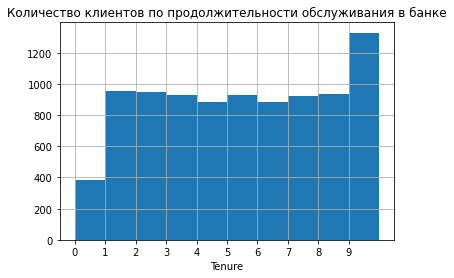

In [8]:
data['Tenure'].hist(bins=10)
plt.xticks(range(0,10))
plt.title('Количество клиентов по продолжительности обслуживания в банке')
plt.xlabel('Tenure')
plt.show()

In [9]:
data.groupby('Tenure')['Exited'].mean()

Tenure
0.0     0.235602
1.0     0.223739
2.0     0.194737
3.0     0.213362
4.0     0.207910
5.0     0.201726
6.0     0.200908
7.0     0.172973
8.0     0.186495
9.0     0.219955
10.0    0.206278
Name: Exited, dtype: float64

In [10]:
data.loc[data['Tenure'].isna(), 'Exited'].mean()

0.20132013201320131

Не похоже, что пропуск это реально отсутствующее значение. В среднем, клиенты с пропуском уходят приблизительно с той же вероятностью, что и клиенты 5 лет обслуживания. Заполним пропуск значением 5. Тип данных приведем к целым

In [11]:
data['Tenure'].fillna(5, inplace=True)
data['Tenure'] = data['Tenure'].astype('int')

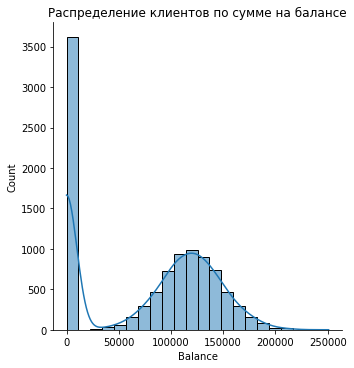

In [12]:
sns.displot(data['Balance'], kde=True)
plt.title('Распределение клиентов по сумме на балансе')
plt.show()

Подозрительно большое количество людей с нулем на балансе, в остальном распределение нормальное.

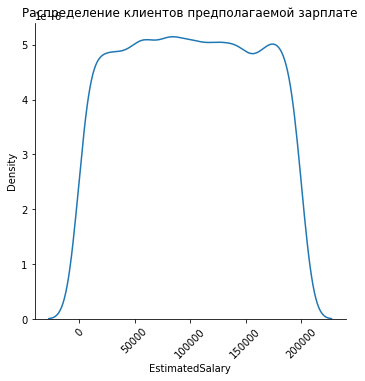

In [13]:
sns.displot(data['EstimatedSalary'], kind='kde')
plt.xticks(rotation=45)
plt.title('Распределение клиентов предполагаемой зарплате')
plt.show()

Околонулевые значения зарплаты показались странными, однако мы видим, что данные распределены равномерно.

### Кодирование переменных, разбиение выборок, масштабирование

In [14]:
features = data.drop('Exited', axis=1)
targets = data['Exited']

In [15]:
data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [16]:
data['Gender'].unique()

array(['Female', 'Male'], dtype=object)

У наших категориальных признаков всего несколько уникальных значений. Значит, когда будем использовать OHE, наш датасет не слишком разрастется в ширину.

In [17]:
#features_ohe = pd.get_dummies(features, drop_first=True)

In [18]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
dtypes: float64(2), int64(6), object(2)
memory usage: 781.4+ KB


In [19]:
targets.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [20]:
features

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


Мы практически подготовили наши данные. Осталось разбить их на выборки и отмасштабировать. <br>
Мы будем использовать отложенную валидационную и тестовую выборки. Для чистоты эксперимента StandartScaler будет обучаться только на тренировочной. В выборке дисбаланс классов, поэтому будем использовать стратификацию

In [21]:
features_train, features_valid, targets_train, targets_valid = train_test_split(features,
                                                                                targets,
                                                                                test_size=0.4,
                                                                                stratify=targets,
                                                                                random_state=1)

In [22]:
features_valid, features_test, targets_valid, targets_test = train_test_split(features_valid,
                                                                              targets_valid,
                                                                              test_size=0.5,
                                                                              stratify=targets_valid,
                                                                              random_state=1)

In [23]:
# проверяем, что нигде не накосячили
print(f'features_train shape {features_train.shape}, targets_train shape {targets_train.shape}')
print(f'features_valid shape {features_valid.shape}, targets_valid shape {targets_valid.shape}')
print(f'features_test shape {features_test.shape}, targets_valid shape {targets_test.shape}')
print('')
print(targets_train.value_counts(normalize=True))
print(targets_valid.value_counts(normalize=True))
print(targets_test.value_counts(normalize=True))

features_train shape (6000, 10), targets_train shape (6000,)
features_valid shape (2000, 10), targets_valid shape (2000,)
features_test shape (2000, 10), targets_valid shape (2000,)

0    0.796333
1    0.203667
Name: Exited, dtype: float64
0    0.7965
1    0.2035
Name: Exited, dtype: float64
0    0.796
1    0.204
Name: Exited, dtype: float64


In [24]:
categorical_features = features_train.select_dtypes(include='object').columns.to_list()
categorical_features

['Geography', 'Gender']

In [25]:
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric_features])

ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
ohe_encoder.fit(features_train[categorical_features])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [26]:
features_train[numeric_features] = scaler.transform(features_train[numeric_features])
features_valid[numeric_features] = scaler.transform(features_valid[numeric_features])
features_test[numeric_features] = scaler.transform(features_test[numeric_features])

In [27]:
# проверяем, что перечень классов между выборками одинаковый
assert set(features_train['Geography'].unique()) ==\
        set(features_valid['Geography'].unique()) ==\
        set(features_test['Geography'].unique()) 

In [28]:
features_train[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(features_train[categorical_features])
features_train.drop(categorical_features, axis=1, inplace=True)

features_valid[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(features_valid[categorical_features])
features_valid.drop(categorical_features, axis=1, inplace=True)

features_test[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(features_test[categorical_features])
features_test.drop(categorical_features, axis=1, inplace=True)

In [29]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
6431,-1.134135,0.002903,-1.423489,-1.218552,-0.925086,0,1,0.154604,0.0,1.0,1.0
7524,0.105387,0.097044,1.112310,1.449089,-0.925086,1,1,1.492613,0.0,0.0,0.0
3430,-0.256140,-0.185380,-1.423489,1.606871,0.791215,1,1,-0.060400,0.0,0.0,1.0
9088,0.890417,-0.279522,1.112310,0.439565,-0.925086,1,1,0.182789,1.0,0.0,0.0
7606,0.311974,-0.750229,-0.698975,0.813226,2.507516,1,1,1.340512,1.0,0.0,0.0


**Вывод** 

Мы изучили полученные данные, заполнили попуски, привели типы данных к правильным, убедились в отсутсвии выбросов и так же разбили датасет на тренировочную, валидационную и тестовую выборки.

В итоге наш обучающий датасет содержит 11 признаков и 6000 наблюдений.

Пришло время попробовать обучить первые модели

## Исследование задачи

Обучим две модели - логистическую регрессию и случайный лес. Гиперпараметры пока оставим по умолчанию. В дальнейшем мы выберем самую перспективную модель и оптимизируем её 


Помимо озвученных в задании метрик мы будем так же считать precision и recall.
    
Recall покажет нам долю от ушедших клиентов, которых модель смогла найти. Precision покажет точность, с которой модель классифицирует уходящих клиентов.
    
Обе метрики важны для бизнеса и между ними нужно найти баланс, который будет иметь смысл именно с точки зрения максимизации прибыли. Поясню на примере: можно считать всех клиентами потенциально потерянными (класс 1). Тогда наш Recall будет равен единице. На основании нашего прогноза соответствующие отделы должны провзаимодействовать с таким клиентом, чтобы удержать его, в случае нашего примера - со всеми клиентами банка. Взаимодействие стоит денег, поэтому затраты могут перевесить потенциальную прибыль. И наоборот, модель с очень высокой точностью будет находить единичные случаи отказников, и мы просто не охватим нужное количество клиентов.
    
Так что мы должны одновременно выявлять много уходящих клиентов, и быть уверенными что мы не ошиблись, чтобы не потратить деньги на их удержание впустую.

In [30]:
def get_report(estimator, model_name):
    '''
    функция для печатания отчета и добавления результатов в
    сводную таблицу итогов по всем моделям, которые мы будем обучать
    '''
    prediction = estimator.predict(features_valid)
    prediction_probs = estimator.predict_proba(features_valid)
    roc_auc = roc_auc_score(targets_valid, prediction_probs[:,1])
    f1 = f1_score(targets_valid, prediction)
    precision = precision_score(targets_valid, prediction)
    recall = recall_score(targets_valid, prediction)
    print(f'f1_score: {f1}')
    print(f'roc_auc: {roc_auc}')
    print(f'precision: {precision}')
    print(f'recall: {recall}')
    
    score_df.loc[-1] = [model_name, f1, roc_auc, precision, recall] 
    score_df.reset_index(inplace=True, drop=True)
    score_df

# таблица с результатами 
score_df = pd.DataFrame(columns=['model', 'f1', 'roc_auc', 'precision', 'recall'])

In [31]:
# в качестве бейзлайна возьмем константный классификатор
dummy_classifier = DummyClassifier(strategy='constant', constant=1)
dummy_classifier.fit(features_train, targets_train)

get_report(dummy_classifier, 'Dummy baseline')

f1_score: 0.3381803074366431
roc_auc: 0.5
precision: 0.2035
recall: 1.0


In [32]:
model_lr = SGDClassifier(random_state=1, loss='log_loss')
model_lr.fit(features_train, targets_train)
get_report(model_lr, 'Linear regression unbalanced')

f1_score: 0.331588132635253
roc_auc: 0.7718072463835174
precision: 0.572289156626506
recall: 0.2334152334152334


In [33]:
%%time
best_model_rf = None
best_score = 0
for depth in range(4, 16):
    for n_estimators in range(40, 120, 10):
        model_rf = RandomForestClassifier(random_state=1, max_depth=depth, n_estimators=n_estimators)
        model_rf.fit(features_train, targets_train)
        prediction = model_rf.predict(features_valid)   
        f1 = f1_score(targets_valid, prediction)
        if f1 > best_score:
            best_model_rf = model_rf
            best_score = f1
            print(f'max_depth: {depth}, n_estimators: {n_estimators}, f1: {f1}')

max_depth: 4, n_estimators: 40, f1: 0.3916349809885931
max_depth: 5, n_estimators: 40, f1: 0.5068493150684932
max_depth: 6, n_estimators: 40, f1: 0.5176470588235295
max_depth: 6, n_estimators: 70, f1: 0.5234899328859061
max_depth: 6, n_estimators: 80, f1: 0.5252525252525252
max_depth: 6, n_estimators: 110, f1: 0.527363184079602
max_depth: 7, n_estimators: 40, f1: 0.546925566343042
max_depth: 7, n_estimators: 70, f1: 0.5553772070626003
max_depth: 7, n_estimators: 90, f1: 0.5568
max_depth: 7, n_estimators: 100, f1: 0.5619047619047619
max_depth: 8, n_estimators: 60, f1: 0.5641838351822503
max_depth: 8, n_estimators: 70, f1: 0.5650793650793651
max_depth: 8, n_estimators: 80, f1: 0.5705229793977813
max_depth: 8, n_estimators: 90, f1: 0.5709779179810726
max_depth: 9, n_estimators: 60, f1: 0.571875
max_depth: 11, n_estimators: 70, f1: 0.5745007680491552
max_depth: 11, n_estimators: 90, f1: 0.5797546012269938
max_depth: 12, n_estimators: 40, f1: 0.582701062215478
max_depth: 12, n_estimators: 5

In [34]:
get_report(best_model_rf, 'Random forest unbalanced')

f1_score: 0.5878787878787879
roc_auc: 0.8393046359148054
precision: 0.766798418972332
recall: 0.47665847665847666


In [35]:
score_df

,model,f1,roc_auc,precision,recall
0,Dummy baseline,0.338180,0.500000,0.203500,1.000000
1,Linear regression unbalanced,0.331588,0.771807,0.572289,0.233415
2,Random forest unbalanced,0.587879,0.839305,0.766798,0.476658


**Вывод** 

качестве промежуточных выводов можно отметить, что модель случайного леса проявила себя лучше. На валидационной выборке целевая метрика **f1 составила 0.5878**, что достаточно близко к поставленной цели

Отдельно отменим, что **auc_score** имеет более высокое значение относительно **f1**. В дальнейшем понаблюдаем, как будет изменяться его значение с повышением целевой метрики

## Борьба с дисбалансом

Выше мы заметили, что соотношение классов примерно 4 к 1. 80% класс 0 и 20% класс 1. Данных не много, так что удалять ничего не будем.

Попробуем сначала обучить модели с параметром **class_weight**, а потом применить технику **upsampling**

In [36]:
model_lr_weighted = SGDClassifier(random_state=1, class_weight='balanced', loss='log_loss')
model_lr_weighted.fit(features_train, targets_train)

get_report(model_lr_weighted, 'Linear regression weighted')

f1_score: 0.41874527588813304
roc_auc: 0.6857011094299229
precision: 0.30240174672489084
recall: 0.6805896805896806


In [37]:
%%time

best_model_rf_weighted = None
best_score = 0
for depth in range(4, 16):
    for n_estimators in range(40, 120, 10):
        model_rf_weighted = RandomForestClassifier(random_state=1,
                                                   max_depth=depth,
                                                   n_estimators=n_estimators,
                                                   class_weight='balanced')
        model_rf_weighted.fit(features_train, targets_train)
        prediction = model_rf_weighted.predict(features_valid)   
        f1 = f1_score(targets_valid, prediction)
        if f1 > best_score:
            best_model_rf_weighted = model_rf_weighted
            best_score = f1
            print(f'max_depth: {depth}, n_estimators: {n_estimators}, f1: {f1}')

max_depth: 4, n_estimators: 40, f1: 0.5691699604743083
max_depth: 4, n_estimators: 50, f1: 0.572844400396432
max_depth: 4, n_estimators: 60, f1: 0.579256360078278
max_depth: 4, n_estimators: 70, f1: 0.5824284304047385
max_depth: 5, n_estimators: 40, f1: 0.5843621399176956
max_depth: 5, n_estimators: 100, f1: 0.5863453815261044
max_depth: 6, n_estimators: 50, f1: 0.5894308943089431
max_depth: 6, n_estimators: 60, f1: 0.5896656534954406
max_depth: 6, n_estimators: 100, f1: 0.5898989898989899
max_depth: 6, n_estimators: 110, f1: 0.5915492957746479
max_depth: 7, n_estimators: 40, f1: 0.5989304812834225
max_depth: 7, n_estimators: 50, f1: 0.6045016077170419
max_depth: 7, n_estimators: 70, f1: 0.6074866310160427
max_depth: 7, n_estimators: 90, f1: 0.6076759061833689
max_depth: 9, n_estimators: 70, f1: 0.6093928980526918
max_depth: 9, n_estimators: 80, f1: 0.611683848797251
CPU times: user 38.9 s, sys: 626 ms, total: 39.6 s
Wall time: 39.9 s


In [38]:
get_report(best_model_rf_weighted, 'Random forest weighted')

f1_score: 0.611683848797251
roc_auc: 0.8450114212826076
precision: 0.572961373390558
recall: 0.6560196560196561


In [39]:
score_df

,model,f1,roc_auc,precision,recall
0,Dummy baseline,0.338180,0.500000,0.203500,1.000000
1,Linear regression unbalanced,0.331588,0.771807,0.572289,0.233415
2,Random forest unbalanced,0.587879,0.839305,0.766798,0.476658
3,Linear regression weighted,0.418745,0.685701,0.302402,0.680590
4,Random forest weighted,0.611684,0.845011,0.572961,0.656020


In [40]:
# def upsample(features, target, repeat):
#     features_ones = features[target == 1]
#     features_zeros = features[target == 0]
#     target_ones = target[target == 1]
#     target_zeros = target[target == 0]
    
#     features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
#     target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
#     features_upsampled, target_upsampled = shuffle(
#                     features_upsampled, target_upsampled, random_state=12345)
    
#     return features_upsampled, target_upsampled

In [41]:
# features_train_upsampled, targets_train_upsampled = upsample(features_train, targets_train, 4)

In [42]:
oversample = SMOTE(random_state=1)
features_train_upsampled, targets_train_upsampled = oversample.fit_resample(features_train, targets_train)

In [43]:
model_lr_upsampled = SGDClassifier(random_state=1, class_weight='balanced', loss='log_loss')
model_lr_upsampled.fit(features_train_upsampled, targets_train_upsampled)

get_report(model_lr_upsampled, 'Linear regression upsampled')

f1_score: 0.46220302375809935
roc_auc: 0.7471986624528997
precision: 0.4123314065510597
recall: 0.5257985257985258


In [44]:
%%time

best_model_rf_upsampled = None
best_score = 0
for depth in range(4, 16):
    for n_estimators in range(40, 120, 10):
        model_rf_upsampled = RandomForestClassifier(random_state=1,
                                                   max_depth=depth,
                                                   n_estimators=n_estimators)
        model_rf_upsampled.fit(features_train_upsampled, targets_train_upsampled)
        prediction = model_rf_upsampled.predict(features_valid)   
        f1 = f1_score(targets_valid, prediction)
        if f1 > best_score:
            best_model_rf_upsampled = model_rf_upsampled
            best_score = f1
            print(f'max_depth: {depth}, n_estimators: {n_estimators}, f1: {f1}')

max_depth: 4, n_estimators: 40, f1: 0.5776397515527951
max_depth: 4, n_estimators: 50, f1: 0.5833333333333334
max_depth: 4, n_estimators: 60, f1: 0.5964546402502606
max_depth: 5, n_estimators: 40, f1: 0.5967567567567569
max_depth: 5, n_estimators: 60, f1: 0.6006458557588805
max_depth: 5, n_estimators: 90, f1: 0.6027987082884823
max_depth: 5, n_estimators: 110, f1: 0.6059322033898306
max_depth: 6, n_estimators: 60, f1: 0.6079484425349087
max_depth: 8, n_estimators: 40, f1: 0.609673790776153
max_depth: 8, n_estimators: 60, f1: 0.6141732283464567
max_depth: 8, n_estimators: 90, f1: 0.6143344709897611
CPU times: user 1min 2s, sys: 982 ms, total: 1min 3s
Wall time: 1min 4s


In [45]:
get_report(best_model_rf_upsampled, 'Random forest upsampled')

f1_score: 0.6143344709897611
roc_auc: 0.8457563881292696
precision: 0.5720338983050848
recall: 0.6633906633906634


In [46]:
score_df.sort_values('f1', ascending=False)

,model,f1,roc_auc,precision,recall
6,Random forest upsampled,0.614334,0.845756,0.572034,0.663391
4,Random forest weighted,0.611684,0.845011,0.572961,0.656020
2,Random forest unbalanced,0.587879,0.839305,0.766798,0.476658
5,Linear regression upsampled,0.462203,0.747199,0.412331,0.525799
3,Linear regression weighted,0.418745,0.685701,0.302402,0.680590
0,Dummy baseline,0.338180,0.500000,0.203500,1.000000
1,Linear regression unbalanced,0.331588,0.771807,0.572289,0.233415


Для модели случайного леса апсемплинг сработал лучше, чем взвешивание. Для модели регрессии наоборот, апсемплинг дал лучший результат

Возьмем сильнейшую модель и попробуем подобрать глубину дерева

Лучший результат **f1 = 0.6143** на отложенной выборке мы получили при параметрах max_depth=8, n_estimators=90

In [47]:
prediction_proba = best_model_rf_upsampled.predict_proba(features_valid)[:,1]

In [48]:
for threshold in np.arange(0.3, 0.7, 0.02):
    prediction = (prediction_proba > threshold)
    print(f'порог: {round(threshold, 4)}, f1: {f1_score(targets_valid, prediction)}')

порог: 0.3, f1: 0.5323965651834505
порог: 0.32, f1: 0.541157294213529
порог: 0.34, f1: 0.5497872340425533
порог: 0.36, f1: 0.5604203152364273
порог: 0.38, f1: 0.5665158371040724
порог: 0.4, f1: 0.575187969924812
порог: 0.42, f1: 0.584795321637427
порог: 0.44, f1: 0.5967413441955193
порог: 0.46, f1: 0.608695652173913
порог: 0.48, f1: 0.6094609460946094
порог: 0.5, f1: 0.6143344709897611
порог: 0.52, f1: 0.6004672897196262
порог: 0.54, f1: 0.6030989272943981
порог: 0.56, f1: 0.6036809815950919
порог: 0.58, f1: 0.5992414664981036
порог: 0.6, f1: 0.6000000000000001
порог: 0.62, f1: 0.5871313672922253
порог: 0.64, f1: 0.589041095890411
порог: 0.66, f1: 0.5802816901408451
порог: 0.68, f1: 0.5726744186046512


Нет смысла изменять порог, лучший результат с дефолтным значением

In [49]:
score_df.sort_values('f1', ascending=False)

,model,f1,roc_auc,precision,recall
6,Random forest upsampled,0.614334,0.845756,0.572034,0.663391
4,Random forest weighted,0.611684,0.845011,0.572961,0.656020
2,Random forest unbalanced,0.587879,0.839305,0.766798,0.476658
5,Linear regression upsampled,0.462203,0.747199,0.412331,0.525799
3,Linear regression weighted,0.418745,0.685701,0.302402,0.680590
0,Dummy baseline,0.338180,0.500000,0.203500,1.000000
1,Linear regression unbalanced,0.331588,0.771807,0.572289,0.233415


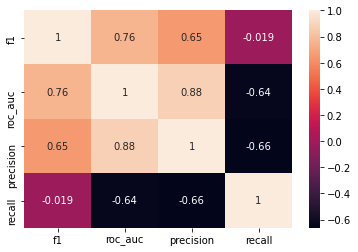

In [50]:
corr = score_df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)
plt.show()

**Вывод**

Борьба с дисбалансом классов помогла улучшить результать на валидационной выборке и превысить требуемое значение.

При исследовании взаимосвязи **f1** и **roc_auc** была выявлена высокая корреляция



## Тестирование модели

В качестве итогой модели выбрана модель случайного леса с максимальной глубиной дерева 10 и количеством деревьев 90. Для финального обучения объединим обучающую и валидационную выборки, произведем апсемплинг редкого класса и проверим итоговый результат на тестовой выборке

*как оказалось, объединение выборкок для повторного обучения ухудшило результат на тестовой выборке. Не совсем понятно, стоит ли вообще таким образом пытаться увеличить размер обучающей выборки, если это может ухудшить модель*

In [51]:
prediction = best_model_rf_upsampled.predict(features_test)
prediction_proba = best_model_rf_upsampled.predict_proba(features_test)

print(f'f1_score {f1_score(targets_test, prediction)}')
print(f'roc_auc {roc_auc_score(targets_test, prediction_proba[:,1])}')
print(f'precision {precision_score(targets_test, prediction)}')
print(f'recall {recall_score(targets_test, prediction)}')

f1_score 0.5901262916188289
roc_auc 0.8495495245837028
precision 0.5550755939524838
recall 0.6299019607843137


Подведем итоги тестирования:

на валиде f1: 0.61433	roc_auc: 0.84575

на тесте  f1:  0.59012   roc_auc: 0.84954

**Вывод**

Поставленная задача по достижению **f1 > 0.59** достигнута

Тестирование модели показало падение целевой метрики по сравнению с валидацией.

Константная модель имеет точность в 20%, следовательно она верно определеят лишь 1 клиента из 5, который покидает банк. Наша модель, в свою очередь, повышает это значение до 55%, мы сможем более адресно проводить меры по удержанию клиента.



